In [1]:
import os
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import h5py
from core import DefaultConfig
import random
import logging

In [2]:
import dataset

gazeCaptureDataset = dataset.HDFDataset(
    hdf_file_path='/root/data/dataset_prep/faze_preprocess/outputs_sted/GazeCapture.h5'
)


In [3]:
def to_01(img: torch.Tensor):
    '''
    change the orinal [-1, 1] scale to [0, 1]
    '''
    return (img + 1) / 2
    

torch.Size([3, 128, 128])
torch.float32


(-0.5, 127.5, 127.5, -0.5)

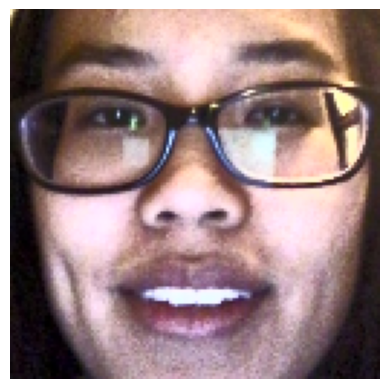

In [25]:
test_img = gazeCaptureDataset[484225]['image_a']
test_img = to_01(test_img)
print(test_img.shape)
print(test_img.dtype) # single precision float

import matplotlib.pyplot as plt
plt.imshow(test_img.permute(1, 2, 0))
plt.axis('off')

In [24]:
# output 50000 samples for encoder inversion training
# + additonal 10000 samples for testing

encoder_dataset_path = '/root/data/dataset_prep/GazeCapture'
train_path = os.path.join(encoder_dataset_path, 'train')
test_path = os.path.join(encoder_dataset_path, 'test')

if not os.path.exists(encoder_dataset_path):
    os.makedirs(encoder_dataset_path)

import tqdm
from concurrent.futures import ThreadPoolExecutor
import torchvision
from PIL import Image

def tensor_to_image(img_tensor: torch.Tensor):
    '''
    convert a tensor of shape (3, H, W) to a numpy array of shape (H, W, 3)
    '''
    img_tensor = to_01(img_tensor)
    return (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

def save_image(img_tensor: torch.Tensor, path: str):
    img = tensor_to_image(img_tensor)
    #cv2.imwrite(path, img)
    img = Image.fromarray(img, mode='RGB')
    img.save(path)

def process_sample(dataset, sample_idx, output_path):
    sample = dataset[sample_idx]
    image_a = sample['image_a']
    image_a_path = os.path.join(output_path, f'{sample_idx}_a.png')
    save_image(image_a, image_a_path)

def process_dataset(dataset, dataset_path, num_workers=14, idx_list=None):
    assert os.path.exists(dataset_path)
    assert idx_list is not None
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_sample, dataset, sample_idx, dataset_path) for sample_idx in idx_list]
        for future in tqdm.tqdm(futures):
            future.result()
# set seed for reproducibility
random.seed(0)
## Train
train_idx_list = np.random.choice(len(gazeCaptureDataset), size=50000, replace=False)
test_idx_list = list(set(range(len(gazeCaptureDataset))) - set(train_idx_list))
test_idx_list = np.random.choice(test_idx_list, size=10000, replace=False)

#plt.imshow(tensor_to_image(gazeCaptureDataset[train_idx_list[2]]['image_a']))


process_dataset(gazeCaptureDataset, train_path, idx_list=train_idx_list, num_workers=16)
process_dataset(gazeCaptureDataset, test_path, idx_list=test_idx_list)




100%|██████████| 50000/50000 [00:38<00:00, 1282.30it/s]


## Inversion Test